# Substructures & substructure filters


In [1]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import csv

In [2]:
with open('Epidermal_growth_factor_receptor_erbB1_IC50.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=";")
    EGFR_ligands = [Chem.MolFromSmiles(m['Smiles']) for m in reader]

suppl = Chem.SDMolSupplier('../data/drugbank.sdf')
drugs = [m for m in suppl if m]

RDKit ERROR: [17:42:14] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [17:42:14] ERROR: Could not sanitize molecule ending on line 20009
RDKit ERROR: [17:42:14] ERROR: Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [17:42:15] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [17:42:15] ERROR: Could not sanitize molecule ending on line 250947
RDKit ERROR: [17:42:15] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [17:42:15] Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: [17:42:15] ERROR: Could not sanitize molecule ending on line 258130
RDKit ERROR: [17:42:15] ERROR: Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: [17:42:15] Can't kekulize mol.  Unkekulized atoms: 57 58 59 60 61 62 63 64 65
RDKit ERROR: 
RDKit ERROR: [17:42:15] ERROR: Could not sanitize molecule ending on line 261581
RDKit ERROR

## Basic substruct search


I've chosen the functional group -NH2 and tried to find a match in F_Amidine and toluene.

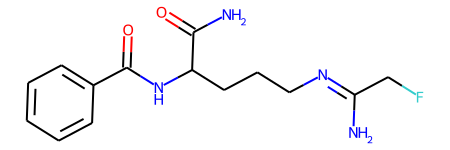

In [141]:
pattern = Chem.MolFromSmarts('[NH2]')

F_Amidine = Chem.MolFromSmiles('C1=CC=C(C=C1)C(=O)NC(CCCN=C(CF)N)C(=O)N') 
F_Amidine

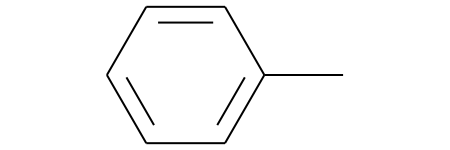

In [142]:
toluene = Chem.MolFromSmiles('Cc1ccccc1')
toluene

In [143]:
F_Amidine.HasSubstructMatch(pattern)

True

In [144]:
toluene.HasSubstructMatch(pattern)

False

As we see everything works well.

In [145]:
# The RDKit functionality also goes well beyond the basic binary does/doesn't match.
# Function GetSubstructMatch will get indices of all matching atoms and bonds
# within the target molecule
import itertools # for getting combinations without having to write additional function
hit_atoms = F_Amidine.GetSubstructMatch(pattern) # indices of matching atoms
hit_bonds = [F_Amidine.GetBondBetweenAtoms(i, j).GetIdx()
             for i, j in itertools.combinations(hit_atoms, 2)
             if F_Amidine.GetBondBetweenAtoms(i, j)]
hit_atoms, hit_bonds

((17,), [])

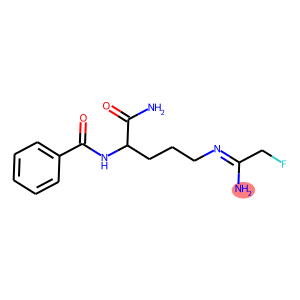

In [146]:
# so the hit matches atoms with IDs 1, 2, 3 and bonds with IDs 1 and 2
# we can even visualize the hits by coloring the hit atoms and bonds
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG
d = rdMolDraw2D.MolDraw2DSVG(300,300)
rdMolDraw2D.PrepareAndDrawMolecule(d, F_Amidine, highlightAtoms=hit_atoms, highlightBonds=hit_bonds)
d.FinishDrawing()
display(SVG(d.GetDrawingText()))

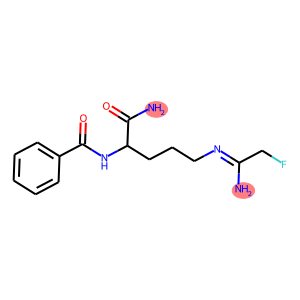

In [147]:
import itertools
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

def visualize_match(structure, pattern):
    # GetSubstructMatches grabs all hits, GetSubstructMatch the first one it finds
    hits = structure.GetSubstructMatches(pattern)
    hit_atoms = set()
    hit_bonds = set()
    for hit in hits:
        hit_atoms.update(hit)
        hit_bonds.update([structure.GetBondBetweenAtoms(i, j).GetIdx()
                          for i, j in itertools.combinations(hit_atoms, 2)
                          if structure.GetBondBetweenAtoms(i, j)])
    d = rdMolDraw2D.MolDraw2DSVG(300,300)
    rdMolDraw2D.PrepareAndDrawMolecule(d, structure, highlightAtoms=hit_atoms, highlightBonds=hit_bonds)
    d.FinishDrawing()
    display(SVG(d.GetDrawingText()))
    
visualize_match(F_Amidine, pattern)

Now, let's have a look how many structures with NH2 groups are in EGFR ligand set, and how many in DrugBank:

In [130]:
NH2_counts_EGFR = [len(m.GetSubstructMatches(pattern)) for m in EGFR_ligands]
NH2_counts_EGFR_nonzero = [m for m in NH2_counts_EGFR if m]
len(NH2_counts_EGFR), len(NH2_counts_EGFR_nonzero), sum(NH2_counts_EGFR_nonzero)/len(NH2_counts_EGFR_nonzero)

(14362, 1985, 1.1032745591939546)

From 14362 EGFR ligands, 1985 structures have the NH2 group, and there are approximatelly 1.1 NH2 groups per ligand.

DrugBank:

In [148]:
NH2_counts_drugbank = [len(m.GetSubstructMatches(pattern)) for m in drugs]
NH2_counts_drugbank_nonzero = [m for m in NH2_counts_drugbank if m]
len(NH2_counts_drugbank), len(NH2_counts_drugbank_nonzero),\
sum(NH2_counts_drugbank_nonzero)/len(NH2_counts_drugbank_nonzero),\
max(NH2_counts_drugbank_nonzero)

(7115, 2110, 1.3023696682464454, 17)

From 7115 drugbank ligands, 2110 structures have the NH2 group, and there are approximatelly 1.3 NH2 group per ligand.

There is at least one with 17 NH2 groups.

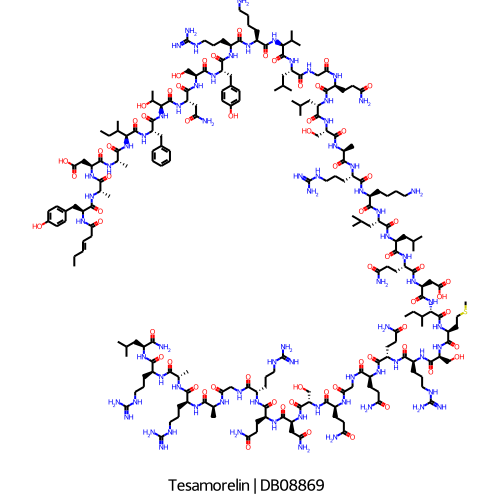

In [132]:
lots_of_NH2 = [m for m, i in zip(drugs, NH2_counts_drugbank) if i == 17]
Draw.MolsToGridImage(lots_of_NH2, molsPerRow=1, subImgSize=(500,500),
                     legends=["{} | {}".format(m.GetProp('GENERIC_NAME'), m.GetProp('DRUGBANK_ID'))
                              for m in lots_of_NH2])

Tesamorelin (INN) (trade name Egrifta) is a synthetic form of growth-hormone-releasing hormone (GHRH) which is used in the treatment of HIV-associated lipodystrophy, approved initially in 2010. It is produced and developed by Theratechnologies, Inc. of Canada. The drug is a synthetic peptide consisting of all 44 amino acids of human GHRH with the addition of a trans-3-hexenoic acid group. (source: Wikipedia)

# PAINS
In addition to our custom queries, there are also established lists of substructures put together for a specific purpose. Widely used, and widely discussed are the PAINS, or [PAn -Assay INterference compoundS](https://www.nature.com/news/chemistry-chemical-con-artists-foil-drug-discovery-1.15991). These are structural patterns that are known to interfere with the mechanism of assays used to screen for substances with a desired biological activity. These structures are likely to come up as false positivies in assays, and might become a trap that consumes time and resources of those unfamiliar with those factors. As always in cheminformatics, PAINS are not a panacea and should be used [with care](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5778390/). They are definitively red flags, though, and you should be definitely aware of them. As shown in the Nature article:

![PAINS](../data/pix/pains.jpg)
![PAINS2](../data/pix/pains2.jpg)

Let's load up some of those PAINS, and see whether your sets of ligands have any of them :)

In [17]:
from itertools import chain
# load PAINS structures in SMARTS format from two files in data
pains = []
with open('../data/pains/p_l15.txt', 'r') as f, open('../data/pains/p_m150.txt', 'r') as p:
    for line in chain(f, p):
        pattern, text = line.strip().split('\t') # split by tab
        pains.append([Chem.MolFromSmarts(pattern),
                      text.lstrip("<regId=\"").rstrip("\">")]) # remove the xml tags
pains, len(pains)

([[<rdkit.Chem.rdchem.Mol at 0x7fc862b793f0>, 'anil_di_alk_F(14)'],
  [<rdkit.Chem.rdchem.Mol at 0x7fc862b769e0>, 'hzone_anil(14)'],
  [<rdkit.Chem.rdchem.Mol at 0x7fc862b79440>, 'het_5_pyrazole_OH(14)'],
  [<rdkit.Chem.rdchem.Mol at 0x7fc862b794e0>, 'het_thio_666_A(13)'],
  [<rdkit.Chem.rdchem.Mol at 0x7fc862b79530>, 'styrene_A(13)'],
  [<rdkit.Chem.rdchem.Mol at 0x7fc862b795d0>, 'ne_rhod_C(13)'],
  [<rdkit.Chem.rdchem.Mol at 0x7fc862b79670>, 'hp_amino_CN_A(13)'],
  [<rdkit.Chem.rdchem.Mol at 0x7fc862b796c0>, 'cyano_imine_C(12)'],
  [<rdkit.Chem.rdchem.Mol at 0x7fc862b79710>, 'thio_urea_A(12)'],
  [<rdkit.Chem.rdchem.Mol at 0x7fc862b797b0>, 'thiophene_amino_B(12)'],
  [<rdkit.Chem.rdchem.Mol at 0x7fc862b79850>, 'keto_keto_beta_B(12)'],
  [<rdkit.Chem.rdchem.Mol at 0x7fc862b79940>, 'keto_phenone_A(11)'],
  [<rdkit.Chem.rdchem.Mol at 0x7fc862b79a30>, 'cyano_pyridone_C(11)'],
  [<rdkit.Chem.rdchem.Mol at 0x7fc862b79b20>, 'thiaz_ene_C(11)'],
  [<rdkit.Chem.rdchem.Mol at 0x7fc862b79c10>, '

In [109]:
for m in EGFR_ligands: # for each ligand
    # add a variable that stores indices of all PAINS patterns that match it
    m.pain_hits = [i for i, pain in enumerate(pains) if m.HasSubstructMatch(pain[0])]

EGFR_with_pains = [m for m in EGFR_ligands if m.pain_hits]
len(EGFR_with_pains)

199

There are 199 structures with PAINS among EGFR ligands. 

Below some of them:

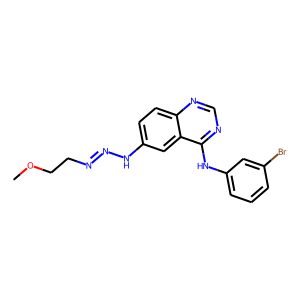

In [119]:
Draw.MolToImage(EGFR_with_pains[23])

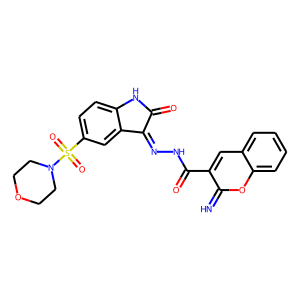

In [133]:
Draw.MolToImage(EGFR_with_pains[7])

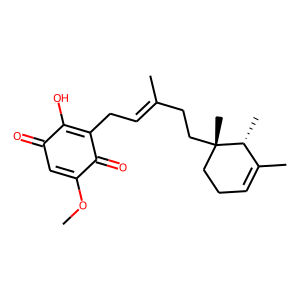

In [134]:
Draw.MolToImage(EGFR_with_pains[92])

In [136]:
print(EGFR_with_pains[23].pain_hits, pains[EGFR_with_pains[23].pain_hits[0]])
print(EGFR_with_pains[7].pain_hits, pains[EGFR_with_pains[7].pain_hits[0]])
EGFR_with_pains[92].pain_hits, pains[EGFR_with_pains[92].pain_hits[0]]

[414] [<rdkit.Chem.rdchem.Mol object at 0x7fc862b8e4e0>, 'azo_A(324)']
[423] [<rdkit.Chem.rdchem.Mol object at 0x7fc862b8ec10>, 'imine_one_isatin(189)']


([413], [<rdkit.Chem.rdchem.Mol at 0x7fc862b8e3f0>, 'quinone_A(370)'])

PAINS visualization in chosen structures:

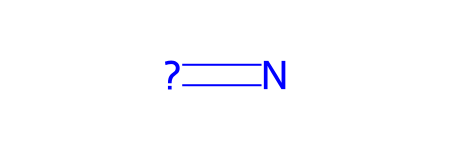

In [31]:
pains[EGFR_with_pains[23].pain_hits[0]][0]

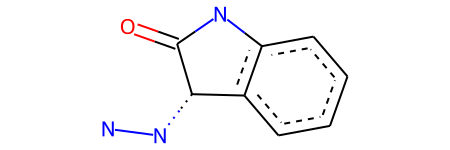

In [137]:
pains[EGFR_with_pains[7].pain_hits[0]][0]

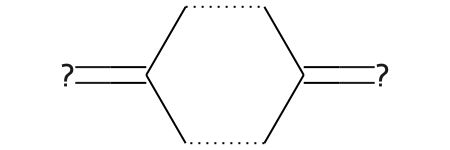

In [138]:
pains[EGFR_with_pains[92].pain_hits[0]][0]

Visualization of match of PAINS and the structures:

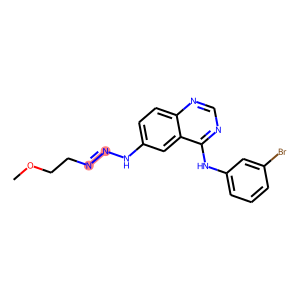

In [32]:
visualize_match(EGFR_with_pains[23], pains[EGFR_with_pains[23].pain_hits[0]][0])

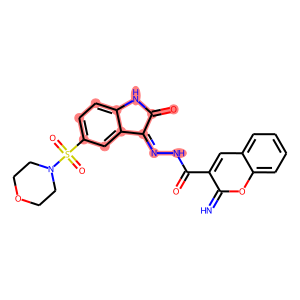

In [139]:
visualize_match(EGFR_with_pains[7], pains[EGFR_with_pains[7].pain_hits[0]][0])

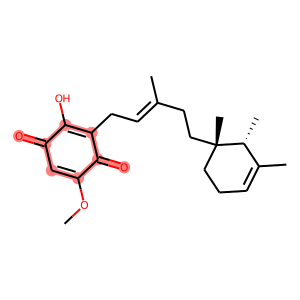

In [140]:
visualize_match(EGFR_with_pains[92], pains[EGFR_with_pains[92].pain_hits[0]][0])